In [8]:
import json
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np
import os, sys, stat, time
import subprocess
from ast import literal_eval
import re
import io
from pandas import read_csv
import shlex
import subprocess as sp

HOME = os.getcwd() #'/Users/anilkoyuncu/Documents/lexar'
LINUX_HOME = '/Users/anilkoyuncu/linux-stable'


#filename = "lkml.json"
def read():
    with open(filename, 'r') as f:
        objects = ijson.items(f, 'item')
        columns = list(objects)
    return colums
def readJson(filename):
    data = []
    with open(filename) as f:
        for line in f:
            data.append(json.loads(line))
    return data

def preProcessJson(filename):
    data = readJson(filename)
    aDf = pd.DataFrame.from_dict(data)
    aDf.to_csv('lkml-all-row',encoding='utf-8',index=False)
    return aDf
    
def cleanDs():
    c1 = pd.read_csv('lkml-all-row',encoding='utf-8',index_col=0)
    #remove the rows with NaN
    df = c1[c1.name.notnull()]
    #insert column for replys
    df['isReply'] = df.name.apply(lambda x:  True if re.search(r'Re: |RE: ',x) else False)
    #insert a column for patches
    df['isPatch'] = df.name.apply(lambda x:  True if re.search(r'PATCH',x,re.IGNORECASE) else False)
    #filter the rows that are not patches
    patches = df[df.isPatch == True]
    #save the patches
    patches.to_csv('lkml-patches',encoding='utf-8',index=False)
    return patches
    
def readGit():
    cmd ="git log --no-merges --pretty=format:'%H\t%aN\t%aE\t%cN\t%cE\t%ai\t%ci\t%f\t%p\t%t\t%s' "


    
    p = sp.Popen(shlex.split(cmd), stdout=sp.PIPE)
    # p.wait() will likely just hang if the log is long enough because the
    # stdout buffer will fill up
    stdout, _ = p.communicate()
    table = read_csv(io.StringIO(stdout.decode('iso-8859-1')), sep='\t',
                 names=['commit', 'author', 'email', 'committer', 'committerEmail', 'authorDate', 'committerDate', 'message', 'parents', 'tree', 'subject'], 
                 parse_dates=True).sort()
    return table
    #git diff a6d3e7d35d088b2aabad1688b740e17bfdf566c5^!

import pickle
import csv
def saveList(aFile,aList):
    with open(aFile, "wb") as fp:
        pickle.dump(aList,fp)
def loadList(aFile):
    with open(aFile, "rb") as fp:
        b = pickle.load(fp)
    return b

def readLKMLPatches(patches):
    patches = pd.read_csv('lkml-patches')
    patchR = patches[patches.articleBody != 'Body for this message unavailable']
    #1739713 patches
    patchR.articleBody = patchR.articleBody.astype('string')
    return patchR

def parse_full_date(row):
    #date = datetime.datetime.utcfromtimestamp(row)
   
    date = row.strftime("%Y-%m")
    return date

def testTools(x):
    #print x
    return pTools[index] in x

def calculateDatePublish(aDf):
    aDf['occurance'] = 1
    return aDf.groupby("datePublished").sum().occurance

def calculateTool(body):
    toolNames = set()
    tools = ['checkpatch','sparse','linux driver verification','smatch','coverity','cppcheck'
                 ,'strace','syzkaller','kasan','coccinelle']
    for tool in tools:
        pattern = re.compile(r'\b%s\b' % tool)
        match = (re.search(pattern,body))
        if match:                
            #save tools indexes
            toolNames.add(tool)
            #print body
    return toolNames



MAX_MESSAGE_LENGTH = 80

def checkTool(body):
    toolNames = set()
    tools = ['checkpatch','sparse','linux driver verification','smatch','coverity','cppcheck'
                 ,'strace','syzkaller','kasan','coccinelle']
    
    isinMail = False
    for tool in tools:
        pattern = re.compile(r'\b%s\b' % tool)
        match = (re.search(pattern,body))
        m = [[match.start(0),match.end(0)] for match in re.finditer(pattern, body)]
        
        if match:  
            for matchedTool in m:
                
                QUOT_PATTERN = re.compile('>+ ?')
                
                z = [m.start(0) for m in re.finditer(QUOT_PATTERN, body)]
                if len(z) > 0:
                    #we have >
                                        
                    if z[0] <= matchedTool[0] and matchedTool[1] <= z[-1] + MAX_MESSAGE_LENGTH:
                        pass
                    else:
                        isinMail = True                    
                            
                else:
                    isinMail = True
    return isinMail

def isToolInMail(aDf):
    toolInMail = aDf.articleBody.apply(checkTool)
    aDf['toolInMail'] = toolInMail
    return aDf



    
def mainMethod():
    
    os.chdir(HOME +'/dataset/lkml')
    #os.chdir(LINUX_HOME)
    #table = readGit()
    #table.to_csv('commits')
    #patches = cleanDs()
    #read the patches
    
    elabToolList = loadList('lkml-tools-elaborated')
    if len(elabToolList) > 0:
        patches = pd.read_csv('lkml-patches',encoding='utf-8')
        patchR = readLKMLPatches(patches)
        #find diffs
        #burada belki yanlis var ya tek elemani varsa noluyo? onu test et cunku cok fazla bos var
        #yok iyi gibi
        patchR['diffs']= patchR.articleBody.apply(lambda x:  ['diff --git{0}'.format(i) for i in re.split(r'[^>] diff --git',x)[1:]])



        patchR['tools'] = patchR.articleBody.apply(calculateTool)

        tools = patchR[patchR.tools.str.len()>0]

        tools.to_csv('lkml-tools')

        #tool dates
        cTools = tools

        converted = cTools.convert_objects(convert_dates='datePublished')

        dCol = converted.datePublished.apply(lambda x:  re.split(r' \(',x)[0] )
        converted.datePublished = dCol
        cDCol = pd.to_datetime(converted['datePublished'])
        #to_csv('t1-' + dirList[i],sep = '\t', index = False , header = False)
        converted.datePublished = cDCol
        mCDCol =converted.datePublished.apply(parse_full_date)
        converted.datePublished = mCDCol
        sortedDF = converted.sort_values(by='datePublished', ascending=True)

        saveList('lkml-tools-sortedDF',sortedDF)

        #a = loadList('lkml-tools-sortedDF')

        toolList = list()
        pTools = ['checkpatch','sparse','linux driver verification','smatch','coverity','cppcheck'
                         ,'strace','syzkaller','kasan','coccinelle']
        for i in range(len(pTools)):
            index = i 
            toolList.append(sortedDF[sortedDF.tools.apply(testTools)])

        elabToolList = list()
        for i in toolList:
            if len(i)> 0:
                aDf = isToolInMail(i)
                elabToolList.append(aDf)
                #bDf = calculateDatePublish(aDf)
                #elabToolList.append(bDf)


        saveList('lkml-tools-elaborated',elabToolList)
        
        
if __name__ == '__main__':
    
    #os.chdir('/Users/anilkoyuncu')
    print('hello')
    #aDs = preProcessJson('mails.json')


hello


In [ ]:
allLKML = pd.read_csv('lkml-all-row',encoding='utf-8')

df = allLKML

df['nameStr'] = df.name.apply(lambda x: (json.dumps(x)))

df['isPatch'] = df.nameStr.apply(lambda x:  True if re.search(r'PATCH',x,re.IGNORECASE) else False)
patches = df[df.isPatch == True]
    #save the patches
patches.to_csv('lkml-patches',encoding='utf-8',index=False)

In [119]:
#os.chdir('/Users/anilkoyuncu')
patches = pd.read_csv('lkml-patches',encoding='utf-8')

In [ ]:
from bs4 import BeautifulSoup as bs
def getArticleBodyStr(aBody):
    aPage = aBody
    out = bs(aPage,'lxml')
    i = (out.select('pre[itemprop]'))
    return json.dumps(i[0].text)

In [ ]:
patches['articleBodyStr'] = patches.articleBody.apply(getArticleBodyStr)

In [ ]:
patches.to_csv('lkml-patches-str',encoding='utf-8',index=False)

In [ ]:
patchR = patches[patches.articleBodyStr != '\"Body for this message unavailable\"']

In [ ]:
            

    #1739713 patches
patchR.articleBodyStr = patchR.articleBodyStr.astype('string')
    
    


patchR['tools'] = patchR.articleBodyStr.apply(calculateTool)

tools = patchR[patchR.tools.str.len()>0]

tools['diffs']= tools.articleBodyStr.apply(lambda x:  ['diff --git{0}'.format(i) for i in re.split(r'[^>] diff --git',x)[1:]])




tools.to_csv('lkml-tools',encoding='utf-8',index=False)

In [7]:

#START FROM HERE
tools = pd.read_csv('dataset/lkml/lkml-tools',encoding='utf-8')


In [ ]:
def getDatePublishedStr(aBody):
    aPage = aBody
    out = bs(aPage,'lxml')
    i = (out.select('td[itemprop]'))
    #print i[0].text
    return i[0].text

In [ ]:
tools['datePublishedStr']=tools.datePublished.apply(getDatePublishedStr)

In [ ]:
#convert pandas column to date
converted = tools.convert_objects(convert_dates='datePublishedStr')



In [ ]:
dCol = converted.datePublishedStr.apply(lambda x:  re.split(r' \(',x)[0] )

converted.datePublishedStr = dCol
cDCol = pd.to_datetime(converted['datePublishedStr'])
converted.datePublishedStr = cDCol
mCDCol =converted.datePublishedStr.apply(parse_full_date)
converted.datePublishedStr = mCDCol
sortedDF = converted.sort_values(by='datePublishedStr', ascending=True)

In [ ]:
saveList('lkml-tools-sortedDF',sortedDF)

In [ ]:
toolList = list()
pTools = ['checkpatch','sparse','linux driver verification','smatch','coverity','cppcheck'
                 ,'strace','syzkaller','kasan','coccinelle']
for i in range(len(pTools)):
    index = i 
    toolList.append(sortedDF[sortedDF.tools.apply(testTools)])

In [ ]:
def isToolInMail(aDf):
    toolInMail = aDf.articleBody.apply(checkTool)
    aDf['toolInMail'] = toolInMail
    return aDf



In [ ]:


def checkTool(body):
    aBody = nonReplyLines(body)
    toolNames = set()
    tools = ['checkpatch','sparse','linux driver verification','smatch','coverity','cppcheck'
                 ,'strace','syzkaller','kasan','coccinelle']
    
    isinMail = False
    for tool in tools:
        pattern = re.compile(r'\b%s\b' % tool)
        
        match = (re.search(pattern,aBody))
        
        if match:
            isinMail = True
    return isinMail

In [ ]:
from bs4 import NavigableString
from bs4 import Tag


def nonReplyLines(ab):
    out = bs(ab,'lxml')
    #print ab
    #print out
    i = (out.select('pre[itemprop]'))
    #print len(i)
    lines = list()
    for br in i[0].findAll('br'):
        next = br.previousSibling
        if not (next and isinstance(next,NavigableString)):
            continue
        next2 = next.previousSibling
        if next2 and isinstance(next2,Tag) and next2.name == 'br':
            next = next.encode('utf-8')
            text = str(next).strip()
            if text:
                #print "Found:", next
                pattern = re.compile(r'^>+ ?')
                match = re.search(pattern,next)
                if not match:
                    lines.append(next)


    return ' '.join(lines)
            
 

In [ ]:
elabToolList = list()
for i in toolList:
    if len(i)> 0:
        aDf = isToolInMail(i)
        elabToolList.append(aDf)
        #bDf = calculateDatePublish(aDf)
        #elabToolList.append(bDf)

In [ ]:

saveList('lkml-tools-elaborated',elabToolList)

In [9]:
#START FROM HERE TO RECOVER
elabToolList  = loadList('dataset/lkml/lkml-tools-elaborated')

In [10]:
frames = [elabToolList[0], elabToolList[1],elabToolList[2],elabToolList[3],elabToolList[4],elabToolList[5],elabToolList[6]
          ,elabToolList[7],elabToolList[8]]

In [11]:
 result = pd.concat(frames)

In [12]:
result.toolInMail.describe()

count     55153
unique        2
top        True
freq      27697
Name: toolInMail, dtype: object

/Users/anilkoyuncu/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


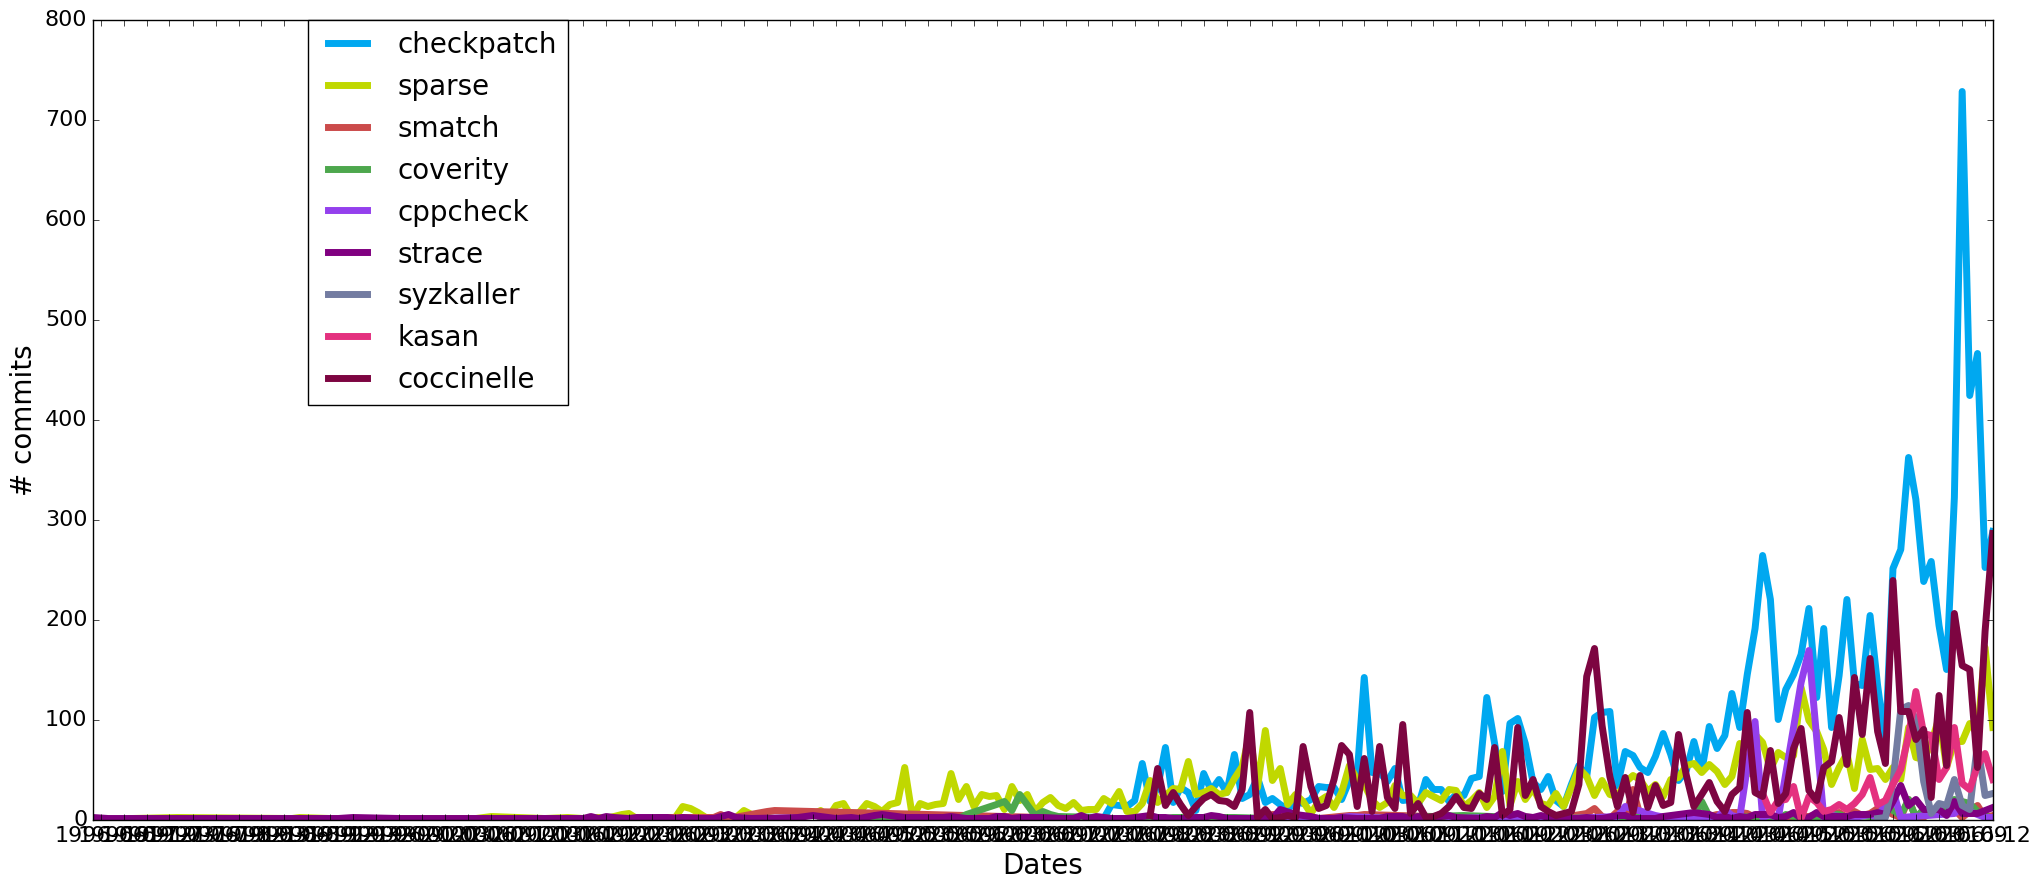

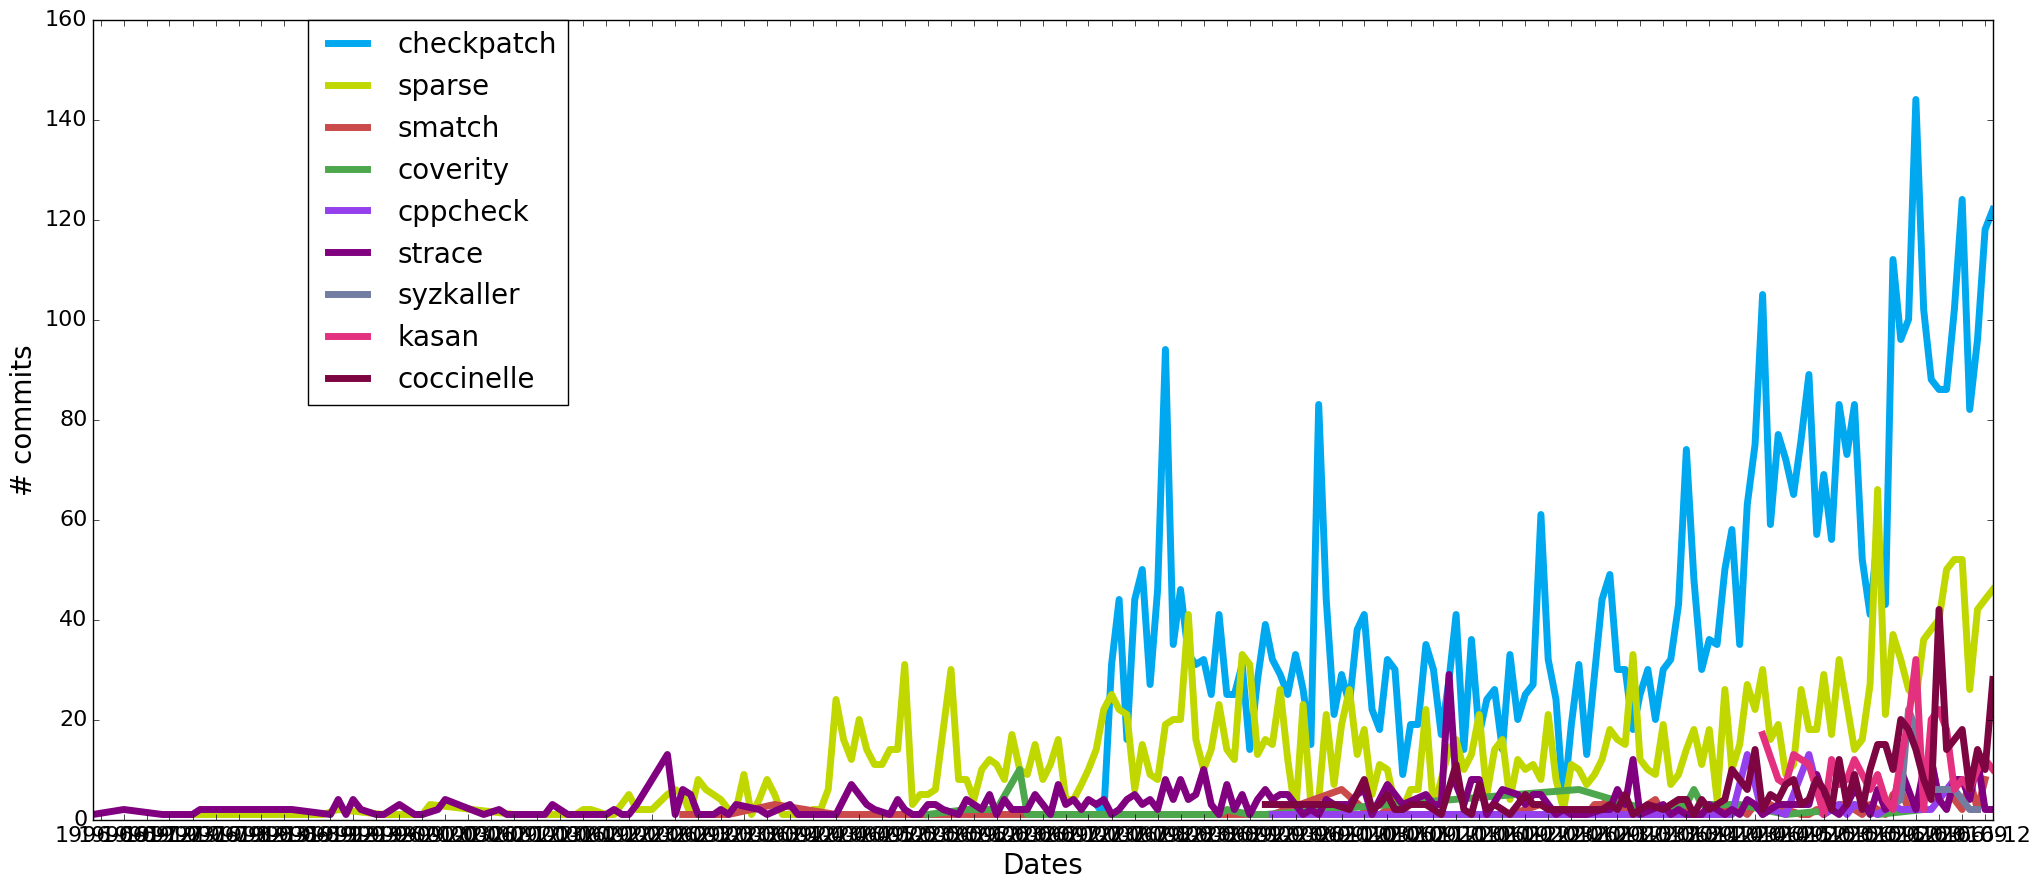

In [6]:
      
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.dates import MonthLocator

def calculateDatePublish(aDf):
    aDf['occurance'] = 1
    return aDf.groupby("datePublishedStr").sum().occurance

def getPatchMentionedTool(selectedTool):
    aTool = selectedTool
    aPatch = aTool[aTool.isReply == False]
    aReply = aTool[aTool.isReply == True]
    aMentionedTool = aReply[aReply.toolInMail == True]
    return [aPatch,aMentionedTool]

def temporalDistOfSemiManual(xy, fileName):
    toolLabels = ['checkpatch','sparse','smatch','coverity','cppcheck'
                 ,'strace','syzkaller','kasan','coccinelle']
    
    #xy = prepareDataFrameSemiManual(ds2)
    #print(xy)
    x1,y1 = xy[0]
    x2,y2 = xy[1]
    x3,y3 = xy[2]
    x4,y4 = xy[3]
    x5,y5 = xy[4]
    x6,y6 = xy[5]
    x7,y7 = xy[6]
    x8,y8 = xy[7]
    x9,y9 = xy[8]
    
    
    plt.figure()
    ax1 = plt.subplot2grid((1,1),(0,0))
    otherColors = ['#00A8F0','#C0D800','#CB4B4B','#4DA74D','#9440ED','#800080','#737CA1','#E4317F','#7D0541','#4EE2EC'
                   ,'#6698FF','#437C17','#7FE817','#FBB117']

    
    ax1.plot_date(x1,y1,'b-', color=otherColors[0],label=toolLabels[0] ,linewidth= 5)
    plt.plot_date(x2,y2,'b-', color=otherColors[1],label=toolLabels[1],linewidth= 5)
    plt.plot_date(x3,y3,'b-', color=otherColors[2],label=toolLabels[2],linewidth= 5)
    plt.plot_date(x4,y4,'b-', color=otherColors[3],label=toolLabels[3],linewidth= 5)
    plt.plot_date(x5,y5,'b-', color=otherColors[4],label=toolLabels[4],linewidth= 5)
    plt.plot_date(x6,y6,'b-', color=otherColors[5],label=toolLabels[5],linewidth= 5)
    plt.plot_date(x7,y7,'b-', color=otherColors[6],label=toolLabels[6],linewidth= 5)
    plt.plot_date(x8,y8,'b-', color=otherColors[7],label=toolLabels[7],linewidth= 5)
    plt.plot_date(x9,y9,'b-', color=otherColors[8],label=toolLabels[8],linewidth= 5)
    
    #ax1.grid(True)#, color='g' , linestyle ='-')

    #ax1.set_yticks([0,50,100,150,200,250])

    '''for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(90)'''
    
    #ax1.spines['left'].set_color('c')

    #ax1.tick_params(axis='x', colors='c')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    ax1.xaxis.set_major_locator(MonthLocator(interval=3))
    #ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    #ax1.set_xticks([2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016])

    
    plt.xlabel('Dates', fontsize=20)
    plt.ylabel('# commits', fontsize=20)
    #plt.title("Temporal dist. of commits", fontsize=18)
    plt.tick_params(labelsize=16)

    plt.subplots_adjust(left=0.03,bottom=0.15,right=0.98, top=0.95 , wspace= 0.1, hspace=0)
    plt.legend(bbox_to_anchor=(0.25, 1), loc=0, borderaxespad=0., fontsize=20)
    plt.ion()
    fig = plt.gcf()
    fig.set_size_inches(20,10, forward=True)
    plt.savefig("LKMLDistCommitsSemiManual"+fileName +".pdf",dpi=100)
    
    

xy = list()
toolPatchList = list()
toolMentionedList = list()
    
for i in elabToolList:
    patchMentionedPair = getPatchMentionedTool(i)
    aDf = calculateDatePublish(patchMentionedPair[0])  
    toolPatchList.append(aDf)
    x = aDf.index.values
    y = aDf.values
    xy.append([x,y])
    
temporalDistOfSemiManual(xy, 'Patches')

xy = list()
for i in elabToolList:
    patchMentionedPair = getPatchMentionedTool(i)
    aDf = calculateDatePublish(patchMentionedPair[1])
    toolMentionedList.append(aDf)
    x = aDf.index.values
    y = aDf.values
    xy.append([x,y])
    
temporalDistOfSemiManual(xy, 'ReplyMentions')

toolLabels = ['checkpatch','sparse','smatch','coverity','cppcheck'
                 ,'strace','syzkaller','kasan','coccinelle']

for i in range(len(toolLabels)):
    toolPatchList[i].to_csv('lkml-patches-'+toolLabels[i])
    toolMentionedList[i].to_csv('lkml-mentioned-'+toolLabels[i])



In [7]:
rList = [0,1,7, 8]

In [8]:
newXY = list()
for i in rList:
    aDf = toolPatchList[i]
    x = aDf.index.values
    y = aDf.values
    newXY.append([x,y])

In [9]:
for i in rList:
    aDf = toolMentionedList[i]
    x = aDf.index.values
    y = aDf.values
    newXY.append([x,y])

In [14]:
tools = ['checkpatch','sparse','kasan']
import ijson
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.dates import MonthLocator


def parse_full_date(row):
    date = datetime.datetime.utcfromtimestamp(int(row["authorDate"]))
    date = date.strftime("%Y-%m")
    return date

def prepareDataFrameSemiManual(ds):
    commits = pd.DataFrame.from_dict(ds)
    
    toolsValues = list()
    for tool in tools:
        toolsValues.append(commits[commits.type == tool])
    xyCommit = list()
    for commit in toolsValues:
        #print commit.type
        #change date format
        commit.reset_index()
        commit["authorDate"] = commit.apply(parse_full_date,axis=1)

        #sort the dataset for the index ( authorDate )
        df = commit["authorDate"].value_counts().sort_index()
        #print(len(df))
        #get the x and y axis 
        x = df.index.values
        y = df.values
        xyCommit.append([x,y])
    #print xyCommit
    return xyCommit

In [15]:
fileType2= 'dataset/t2.json'
fileType1 = 'dataset/t1.json'
import ijson
def datasetReader(filename):
    with open(filename, 'r') as f:
        objects = ijson.items(f, 'item')
        rows = list(objects)
    return rows

#os.chdir('/Users/anilkoyuncu/patchstudy/scripts')
dsType2 = datasetReader(fileType2)

commitList=(prepareDataFrameSemiManual(dsType2))

/Users/anilkoyuncu/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
def prepareDataFrameCocci(ds):
    commit = pd.DataFrame.from_dict(ds)
    

    xyCommit = list()
    
    commit["authorDate"] = commit.apply(parse_full_date,axis=1)

    #sort the dataset for the index ( authorDate )
    df = commit["authorDate"].value_counts().sort_index()
    #print(len(df))
    #get the x and y axis 
    x = df.index.values
    y = df.values
    xyCommit.append([x,y])
    #print xyCommit
    return xyCommit

In [18]:
fileType1 = 'dataset/t1.json'
dsType1 = datasetReader(fileType1)

cocciList=(prepareDataFrameCocci(dsType1))




#find the patch with max files touched
t1 = pd.DataFrame.from_dict(dsType1)

max(t1.paths.str.len().tolist())

t1[t1.paths.str.len() == 188]









import heapq
heapq.nlargest(5, t1.paths.str.len())

[381, 339, 230, 218, 188]

In [ ]:
def getFileCount(paths):
    for path in paths:
        

In [14]:
cList = [0,1,2]
for i in cList:
    aDf = commitList[i]

    newXY.append(aDf)

In [15]:
newXY.append(cocciList[0])

In [54]:
saveList('lkml-graph-data', newXY)

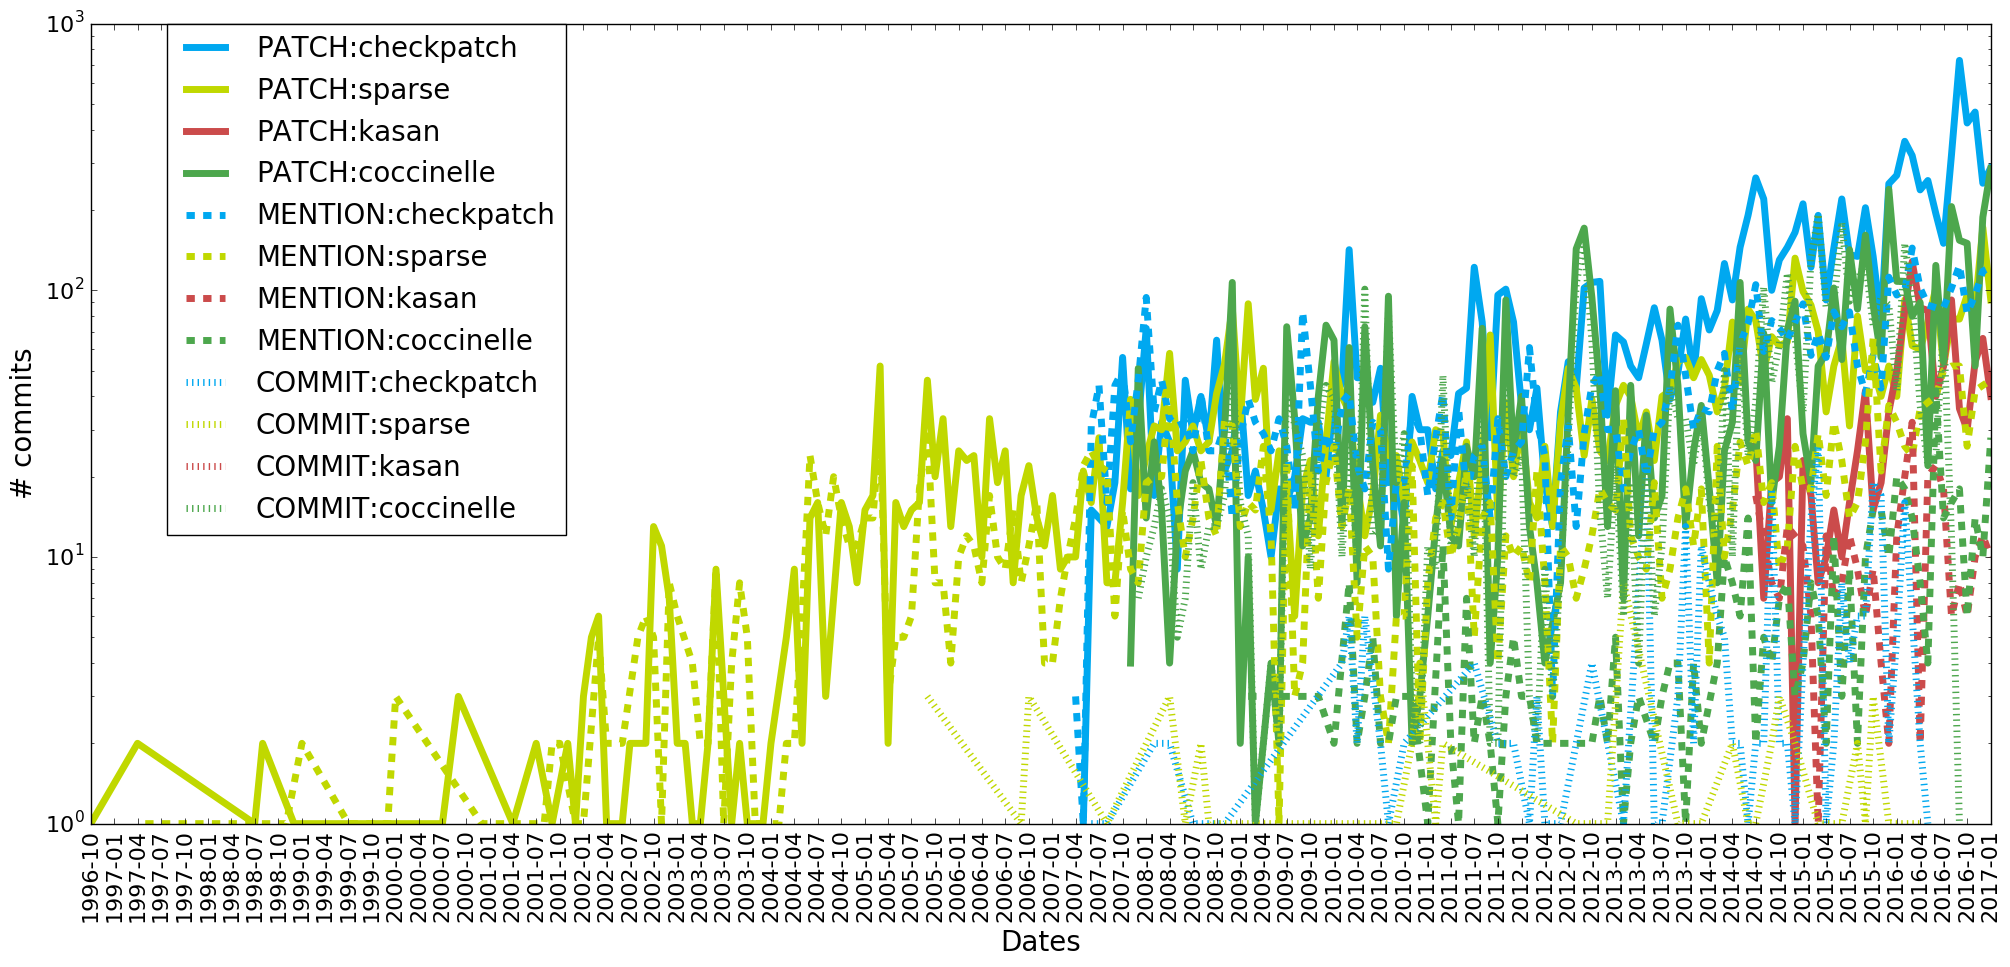

In [68]:
plot(newXY)

In [86]:
commitIndexes = list()
cList = [0,1,2]
for i in cList:
    aDf = commitList[i]
    commitIndexes.append(aDf)

In [95]:
c1 = commitIndexes[0][0].tolist()
c2 = commitIndexes[1][0].tolist()
c3 = commitIndexes[2][0].tolist()

In [97]:
commitDates = c1 + c2 + c3

In [98]:
sortedCommitDates = sorted(list(set(commitDates)))

In [127]:
columns = [ 'dates', 'occurence', 'type' ]    
dateDf = pd.DataFrame(columns=columns) 

In [129]:
ind = 0
for i in range(len(newXY)):
    aType = newXY[i]
    date = newXY[i][0].tolist()
    occ = newXY[i][1].tolist()
    for d,o in zip(date,occ):
        if d in sortedCommitDates:
            dateDf.loc[ind] = [d, int(o), int(i)]
            ind = ind +1

In [143]:
def parse_full_date(row):
    #date = datetime.datetime.utcfromtimestamp(int(row["dates"]))
    #date = row.strftime("%Y")
    date = datetime.datetime.strptime(row, '%Y-%m').strftime('%Y')
    return date

In [135]:
converted = dateDf.convert_objects(convert_dates='dates')



/Users/anilkoyuncu/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [145]:
converted['year'] = converted.dates.apply(parse_full_date)

In [339]:
convertedToolList = list()
converted0 = converted[converted.type == 0.0]
converted1 = converted[converted.type == 1.0]
converted2 = converted[converted.type == 2.0]
converted3 = converted[converted.type == 3.0]
converted4 = converted[converted.type == 4.0]
converted5 = converted[converted.type == 5.0]
converted6 = converted[converted.type == 6.0]
converted7 = converted[converted.type == 7.0]
converted8 = converted[converted.type == 8.0]
converted9 = converted[converted.type == 9.0]
converted10 = converted[converted.type == 10.0]
converted11 = converted[converted.type == 11.0]

In [166]:
convertedToolList = list()
converted0 = converted[converted.type == 0.0]
converted1 = converted[converted.type == 1.0]
converted2 = converted[converted.type == 2.0]
converted3 = converted[converted.type == 3.0]
converted4 = converted[converted.type == 4.0]
converted5 = converted[converted.type == 5.0]
converted6 = converted[converted.type == 6.0]
converted7 = converted[converted.type == 7.0]
converted8 = converted[converted.type == 8.0]
converted9 = converted[converted.type == 9.0]
converted10 = converted[converted.type == 10.0]
converted11 = converted[converted.type == 11.0]
convertedToolList.append(converted0[['year','occurence']])
convertedToolList.append(converted1[['year','occurence']])
convertedToolList.append(converted2[['year','occurence']])
convertedToolList.append(converted3[['year','occurence']])
convertedToolList.append(converted4[['year','occurence']])
convertedToolList.append(converted5[['year','occurence']])
convertedToolList.append(converted6[['year','occurence']])
convertedToolList.append(converted7[['year','occurence']])
convertedToolList.append(converted8[['year','occurence']])
convertedToolList.append(converted9[['year','occurence']])
convertedToolList.append(converted10[['year','occurence']])
convertedToolList.append(converted11[['year','occurence']])

In [20]:
toolLabels = ['PATCH:checkpatch','PATCH:sparse','PATCH:kasan','PATCH:coccinelle',
                  'MENTION:checkpatch','MENTION:sparse','MENTION:kasan','MENTION:coccinelle',
                  'COMMIT:checkpatch','COMMIT:sparse','COMMIT:kasan','COMMIT:coccinelle']

In [177]:
toolLabels[0]

'PATCH:checkpatch'

In [ ]:
to_csv('t1-' + dirList[i],sep = '\t', index = False , header = False)

In [179]:
os.getcwd()

'/Users/anilkoyuncu/patchstudy/scripts'

In [181]:
os.chdir('/Users/anilkoyuncu/patchstudy/scripts/data_lkml')

In [184]:
for i in range(12):
    convertedToolList[i].groupby("year").sum().to_csv(toolLabels[i],sep = '\t', header = False)

In [ ]:
pd.merge(T1, T2, on=T1.index, how='outer')

In [26]:
tmp = pd.merge(readTools[0],readTools[4],on='Year')
checkpatch = pd.merge(tmp, readTools[8], on= 'Year')

In [ ]:
convertedToolList = list()
converted0 = converted[converted.type == 0.0]
converted1 = converted[converted.type == 1.0]
converted2 = converted[converted.type == 2.0]
converted3 = converted[converted.type == 3.0]
converted4 = converted[converted.type == 4.0]
converted5 = converted[converted.type == 5.0]
converted6 = converted[converted.type == 6.0]
converted7 = converted[converted.type == 7.0]
converted8 = converted[converted.type == 8.0]
converted9 = converted[converted.type == 9.0]
converted10 = converted[converted.type == 10.0]
converted11 = converted[converted.type == 11.0]

In [375]:
tmp = pd.merge(converted0,converted4,on='dates',how='outer')
checkpatch = pd.merge(tmp, converted8, on= 'dates',how='outer')

tmp = pd.merge(converted1,converted5,on='dates',how='outer')
sparse = pd.merge(tmp, converted9, on= 'dates',how='outer')

tmp = pd.merge(converted2,converted6,on='dates',how='outer')
kasan = pd.merge(tmp, converted10, on= 'dates',how='outer')

tmp = pd.merge(converted3,converted7,on='dates',how='outer')
coccinelle = pd.merge(tmp, converted11, on= 'dates',how='outer')

In [28]:
checkpatch  = checkpatch.fillna(0.0)
sparse = sparse.fillna(0.0)
kasan = kasan.fillna(0.0)
coccinelle = coccinelle.fillna(0.0)

In [27]:
tmp = pd.merge(readTools[1],readTools[5],on='Year',how='outer')
sparse = pd.merge(tmp, readTools[9], on= 'Year',how='outer')





tmp = pd.merge(readTools[2],readTools[6],on='Year',how='outer')
kasan = pd.merge(tmp, readTools[10], on= 'Year',how='outer')







tmp = pd.merge(readTools[3],readTools[7],on='Year')
coccinelle = pd.merge(tmp, readTools[11], on= 'Year')

kasan.fillna(0)

,Year,Occurance_x,Occurance_y,Occurance
0,2005,0.0,0.0,0.0
1,2006,0.0,0.0,0.0
2,2007,0.0,0.0,0.0
3,2008,0.0,0.0,0.0
4,2009,0.0,0.0,0.0
5,2010,0.0,0.0,0.0
6,2011,0.0,0.0,0.0
7,2012,0.0,0.0,0.0
8,2013,0.0,0.0,0.0
9,2014,106.0,45.0,0.0


In [355]:
def organize(aDf):
    aDf = aDf.set_index('dates')
    aDf= aDf[['occurence_x','occurence_y','occurence']]
    aDf.columns = [ 'Patch', 'Mention', 'Commit']
    aDf.index.name = None
    return aDf
    

checkpatch = organize(checkpatch)
sparse = organize(sparse)
kasan = organize(kasan)
coccinelle = organize(coccinelle)

In [23]:
readTools = list()
for i in range(12):
    readTools.append(pd.read_csv('dataset/lkml/' + toolLabels[i],sep = '\t',names = ["Year", "Occurance"]))

In [223]:
patch = [0,1,2,3,4,5,6,7,8,9,10,11]
commit = [0,1,2,3,4,5,6,7,8,9,10,11]
mention = [0,1,2,3,4,5,6,7,8,9,10,11]

In [233]:
readTools[8].Occurance

0       0.0
1       0.0
2       2.0
3       6.0
4       0.0
5      23.0
6       8.0
7      10.0
8      53.0
9      51.0
10    109.0
11     30.0
Name: Occurance, dtype: float64

In [29]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

def plot_clustered_stacked(dfall,toolName, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""
    HATCHES = ['/','*', '+', '.']
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    plt.figure()
    f, axe = plt.subplots(1, figsize=(8,5))#plt.subplot(111)
    #plt.subplots(1, figsize=(10,5))

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    xList = list()
    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                
                #rect.set_x(((rect.get_x()) + 1 / float(n_df + 1) * i / float(n_col)))
                #xList.append(((rect.get_x()/4) + 1 / float(n_df + 1) * i / float(n_col)))
                #print (rect.get_x()/2)
                #rect.set_hatch(H * int(i / n_col)) #edited part  
                rect.set_hatch(HATCHES[int(i / n_col)])
                #rect.set_color('black')
                rect.set_edgecolor('black')
                
                #print int(i / n_col)
                #print 1 / float(n_df + 1)
                rect.set_width((1 / float(n_df + 1))-0.3)

    #axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2)
    #print (np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1) ) / 3.
    #axe.set_xticks(xList*5)
    axe.set_xticklabels(df.index, rotation = 0)
    
    #axe.set_title(title)
    for label in axe.xaxis.get_ticklabels():
        label.set_rotation(90)
        
    axe.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    axe.xaxis.set_major_locator(MonthLocator(interval=1))

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        print i
        n.append(axe.bar(0, 0, color="gray", hatch=HATCHES[i]))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    #axe.set_rasterized(True)
    plt.ion()
    f = plt.gcf()
    f.set_size_inches(8,5, forward=True)
    plt.subplots_adjust(left=0.03,bottom=0.15,right=0.88, top=0.95 , wspace= 0.1, hspace=0)
    axe.patch.set_alpha(0.1)
    axe.patch.set_edgecolor('black')
    
    plt.savefig('plots/'+toolName +'DistOfLKML.pdf',dpi=600)
    return axe



# Then, just call :
plot_clustered_stacked([checkpatch],'checkpatch',['checkpatch'])

0


In [548]:
checkpatch.to_csv('lkml-checkpatch.csv')

In [549]:
sparse.to_csv('lkml-sparse.csv')

In [550]:
kasan.to_csv('lkml-kasan.csv')

In [551]:
coccinelle.to_csv('lkml-coccinele.csv')

0


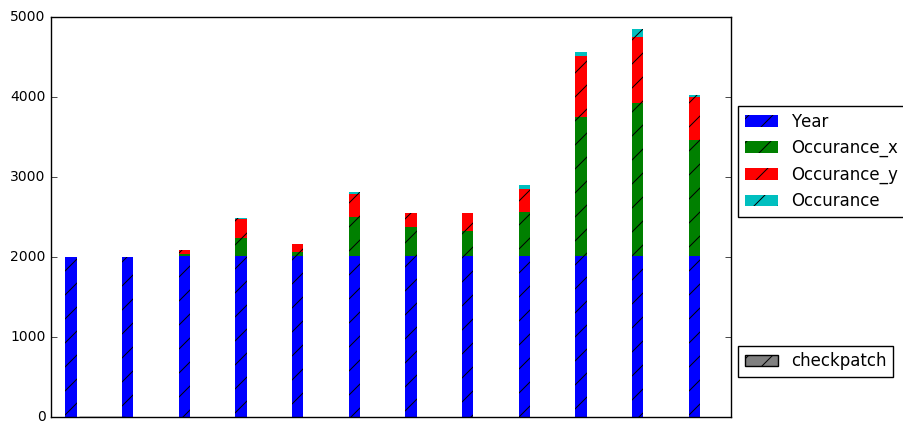

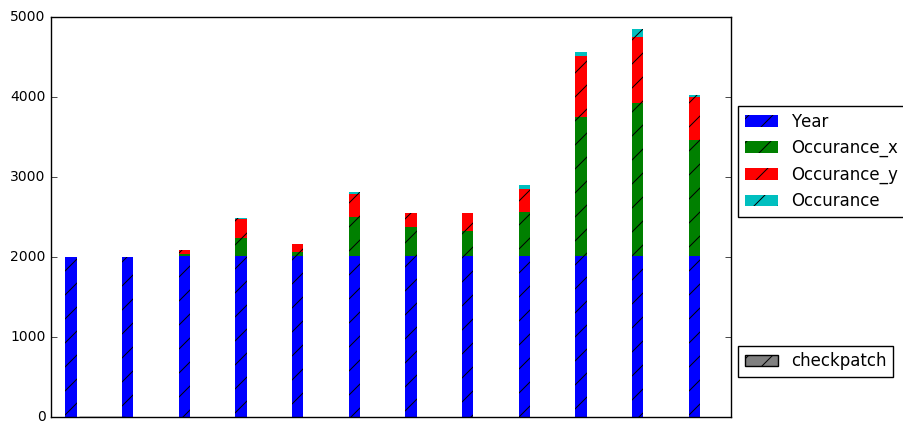

In [30]:
plot_clustered_stacked([checkpatch],'checkpatch',['checkpatch'])

0


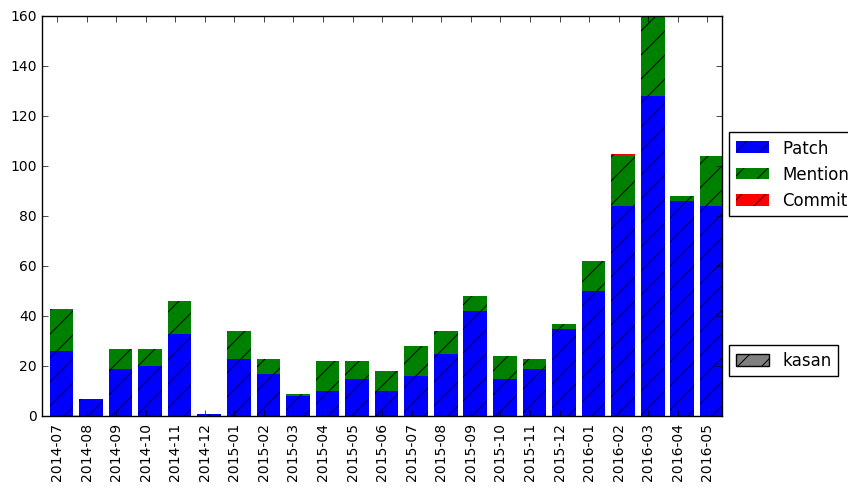

In [531]:
plot_clustered_stacked([kasan],'kasan',['kasan'])

0


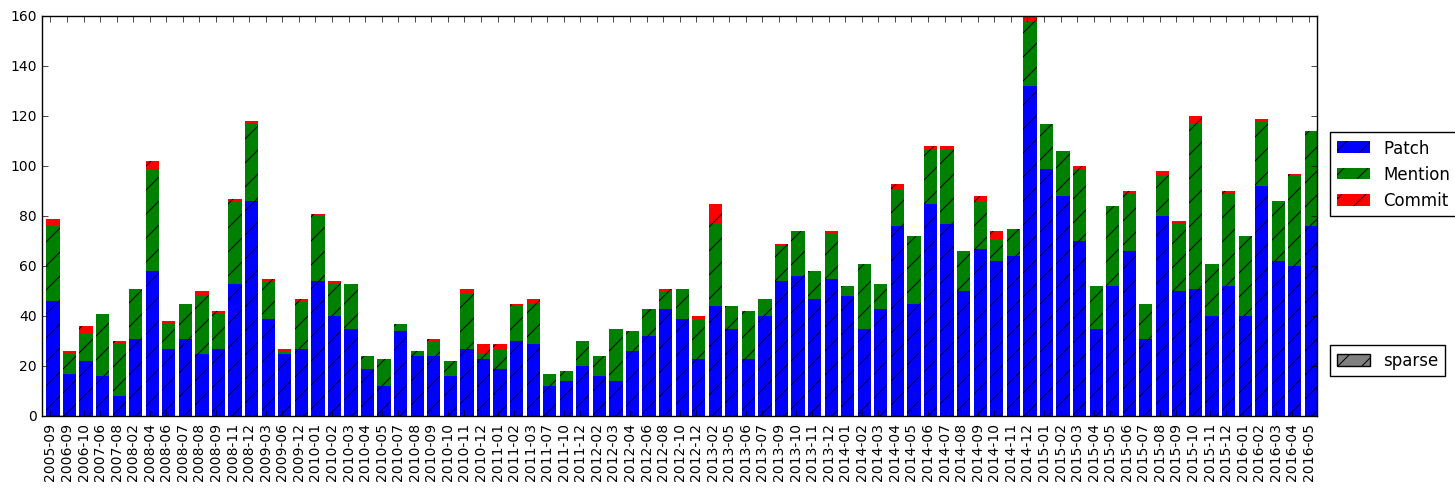

In [525]:
plot_clustered_stacked([sparse],'sparse',['sparse'])

0


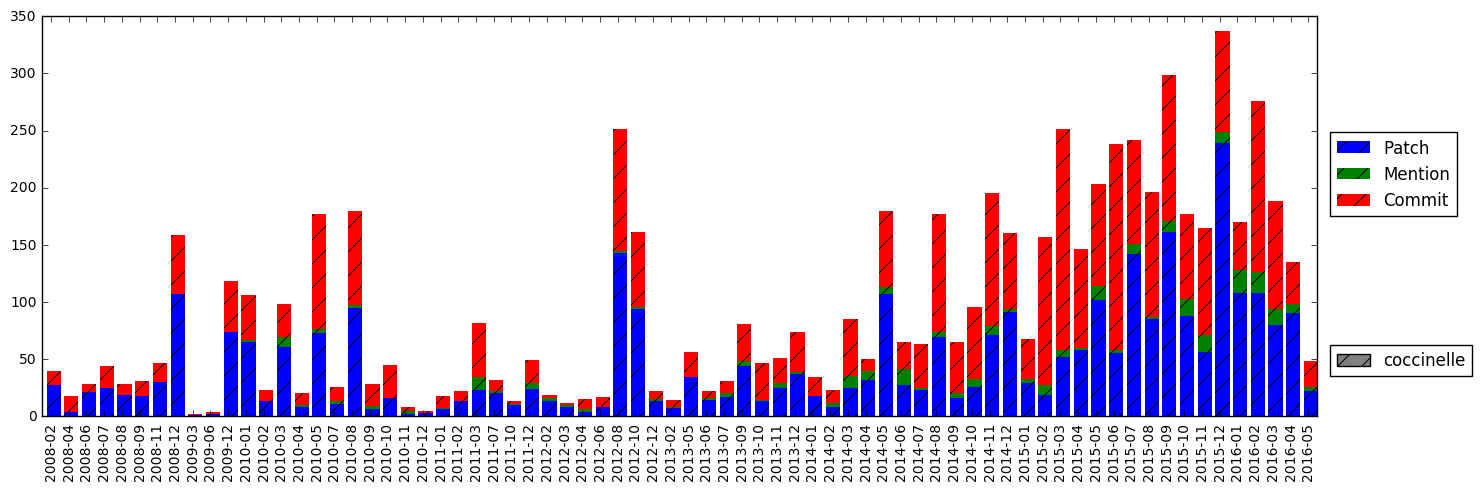

In [527]:
plot_clustered_stacked([coccinelle],'coccinelle',['coccinelle'])